# **AKBAR AMIN AKMALUDIN** **22171065002**

# DETEKSI TOTAL DARI STRUK PEMBELIAN

In [1]:
!pip install easyocr

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 23.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 180.7/180.7 kB 20.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 978.2/978.2 kB 63.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 300.6/300.6 kB 28.6 MB/s eta 0:00:00



=== SCANNER STRUK V3 (LOGIKA TETANGGA) ===


Saving struk kopi.jpg to struk kopi.jpg

⏳ Memuat AI...
Progress: |██████████████████████████████████████████████████| 100.0% Complete

Progress: |██████████████████████████████████████████████████| 100.0% Complete🔄 Memproses: struk kopi.jpg
🔎 Kata kunci ditemukan di baris: 'Total Belanja'
✅ SUKSES! Total Terdeteksi: Total Belanja Rp 8.500


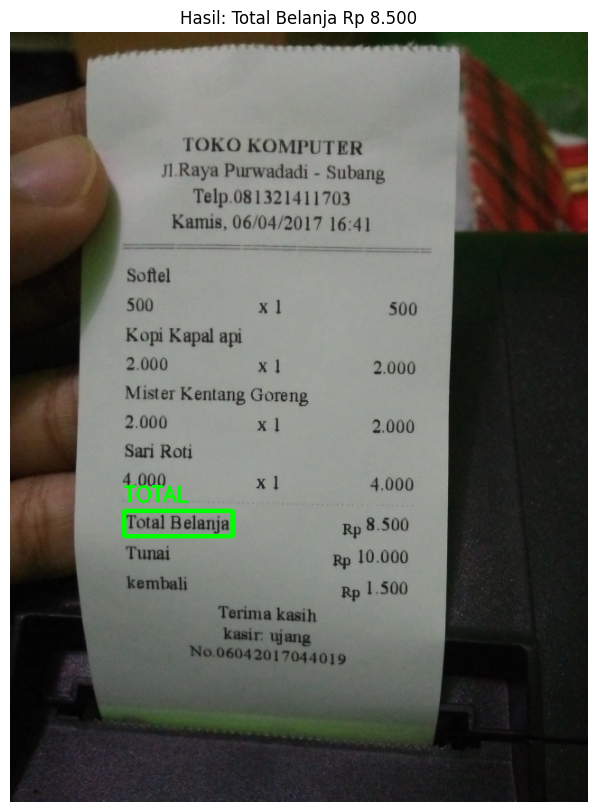

In [2]:
# ==========================================
# DETEKSI STRUK
# ==========================================

import easyocr
import cv2
import numpy as np
import matplotlib.pyplot as plt
import re
from google.colab import files

def bersihkan_angka(teks):
    """Mengambil hanya angka dari string (contoh: 'Rp 875.000' -> '875000')"""
    # Hapus semua kecuali angka
    return re.sub(r'\D', '', teks)

def cari_total_cerdas(hasil_ocr_list):
    """
    Mencari total dengan mengecek baris saat ini DAN baris tetangganya.
    """
    # 1. Tentukan Kata Kunci
    keywords = ['total', 'jumlah', 'bayar', 'grand total', 'tagihan']

    # Loop semua baris teks yang terbaca
    for i, (bbox, text, prob) in enumerate(hasil_ocr_list):
        text_lower = text.lower()

        # Cek apakah baris ini mengandung kata kunci "Total"
        if any(k in text_lower for k in keywords):
            print(f"🔎 Kata kunci ditemukan di baris: '{text}'")

            # --- SKENARIO 1: Angka ada di baris yang SAMA ---
            # Contoh: "Total Rp 875.000"
            if re.search(r'\d', text):
                return text, bbox

            # --- SKENARIO 2: Angka ada di baris BERIKUTNYA (i+1) ---
            # Contoh: Baris i="Total", Baris i+1="875.000"
            if i + 1 < len(hasil_ocr_list):
                teks_tetangga_1 = hasil_ocr_list[i+1][1]
                if re.search(r'\d', teks_tetangga_1):
                    # Kita anggap ini jawabannya, tapi kita kembalikan bbox baris "Total"
                    # agar kotaknya tetap di label "Total"
                    return f"{text} {teks_tetangga_1}", bbox

            # --- SKENARIO 3: Angka ada di 2 BARIS SETELAHNYA (i+2) ---
            # Contoh: Baris i="Total", Baris i+1="Rp", Baris i+2="875.000" (KASUS ANDA)
            if i + 2 < len(hasil_ocr_list):
                teks_tetangga_2 = hasil_ocr_list[i+2][1]
                if re.search(r'\d', teks_tetangga_2):
                    return f"{text} {hasil_ocr_list[i+1][1]} {teks_tetangga_2}", bbox

    return None, None

def jalankan_scanner_final():
    print("\n=== SCANNER STRUK V3 (LOGIKA TETANGGA) ===")
    uploaded = files.upload()

    print("\n⏳ Memuat AI...")
    reader = easyocr.Reader(['id', 'en'], gpu=True)

    for fn in uploaded.keys():
        print(f"🔄 Memproses: {fn}")
        file_bytes = np.frombuffer(uploaded[fn], np.uint8)
        img = cv2.imdecode(file_bytes, cv2.IMREAD_COLOR)

        # PENTING: Kita matikan paragraph=True agar bisa akses per baris/item
        hasil_scan = reader.readtext(img)

        # Cari Total
        teks_ditemukan, koordinat = cari_total_cerdas(hasil_scan)

        img_hasil = img.copy()

        if teks_ditemukan:
            print(f"✅ SUKSES! Total Terdeteksi: {teks_ditemukan}")

            # Gambar kotak di lokasi kata "Total" ditemukan
            (tl, tr, br, bl) = koordinat
            titik_atas = (int(tl[0]), int(tl[1]))
            titik_bawah = (int(br[0]), int(br[1]))

            cv2.rectangle(img_hasil, titik_atas, titik_bawah, (0, 255, 0), 4)
            cv2.putText(img_hasil, "TOTAL", (titik_atas[0], titik_atas[1] - 10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 0), 2)
        else:
            print("❌ Masih belum ketemu. Coba foto bagian Total lebih dekat.")

        plt.figure(figsize=(8, 10))
        plt.imshow(cv2.cvtColor(img_hasil, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.title(f"Hasil: {teks_ditemukan}")
        plt.show()

jalankan_scanner_final()